In [1]:
# 1. My current implementation of the Differentiable Darmois construction does not have triangular Jacobian
# 2. That is because the MAF implementation employs flow.Reverse() layers, which change the order of the variables across successive layers
# 3. If I remove those, the network does not appear to learn any nonlinear transformation for the 1st component; it only applies an (almost?) linear transformation to the first variable
# 4. (Additionally, there appears to be some problem with the Jacobian... Somehow I don't manage to figure out  
#     how to evaluate it -- neither with nor without vmap -- on the Flow and get the correct dimensionality.)

# QUESTIONS: 1. Can I find a better autoregressive flow, more expressive than MAF? -> A: Try Neural Spline Flows.
#            2. Can I evaluate the Jacobian properly with it?

# Alternative path
# 5. Focuse on closed form implementation for now
# 6. Try again with Neural Spline Flows

In [2]:
# For the closed form implementation you might need the error function and/or its inverse, possibly in a differentiable form

In [3]:
from jax import numpy as np

### 1. Generate data from a uniform distribution

In [4]:
# N:=Number of samples
N = 60000
# D:=Number of dimensions
D = 2

In [5]:
from jax import random
key = random.PRNGKey(0)

S = random.uniform(key, shape=(N, D), minval=0.0, maxval=1.0)

In [6]:
from plotting import cart2pol

_, phi = cart2pol( S[:,0]-0.5, S[:,1]-0.5)

colors = phi

In [7]:
import matplotlib.pyplot as plt

In [8]:
from plotting import scatterplot_variables

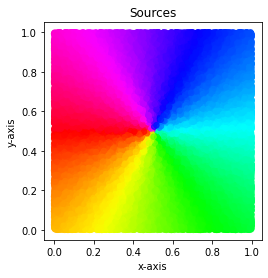

In [9]:
scatterplot_variables(S, 'Sources', colors=colors)

### 2. Mixing (CDF + linear)

In [24]:
A = random.multivariate_normal(key, mean=np.zeros(D*2), cov=np.eye(2*D)).reshape(2,2)
A = np.sqrt(np.abs(A))*np.sign(A)
A

# from scipy.stats import ortho_group
# A = ortho_group.rvs(dim=2)

DeviceArray([[ 1.3476223, -0.8688413],
             [ 0.583    , -0.7313245]], dtype=float32)

In [25]:
A.shape

(2, 2)

In [26]:
A_inv = np.linalg.inv(A)

In [27]:
from jax.scipy import special

In [28]:
from mixing_functions import f_g_unl

In [29]:
# Norm.shape
from jax import vmap

In [30]:
# Apply a linear mixing

f_unl, f_unl_inv = f_g_unl(A)

f_unl_batched = vmap(f_unl)
# X = A @ S_normal 
X = f_unl_batched(S)
# X = A @ Norm

f_unl_inv_batched = vmap(f_unl_inv)

Y = f_unl_inv_batched(X)

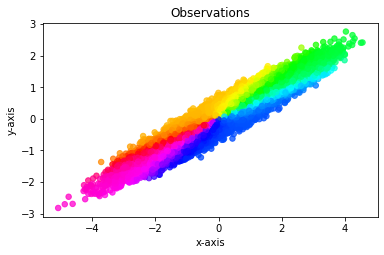

In [31]:
scatterplot_variables(X, 'Observations', colors=colors)

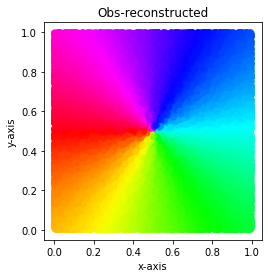

In [32]:
scatterplot_variables(Y, 'Obs-reconstructed', colors=colors)

### 3. Build Darmois

In [33]:
from mixing_functions import darmois_linear_gaussian

In [34]:
darmois_single, inv_darmois_single = darmois_linear_gaussian(A)
darmois, inv_darmois = vmap(darmois_single), vmap(inv_darmois_single)

In [35]:
Y = darmois(X)

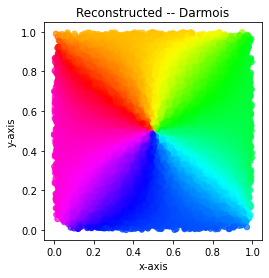

In [36]:
scatterplot_variables(Y, 'Reconstructed -- Darmois', colors=colors)

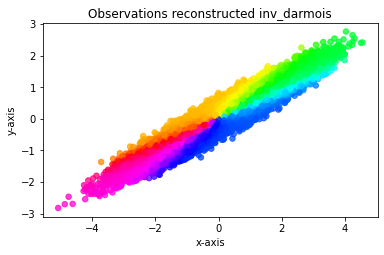

In [37]:
X_ = inv_darmois(Y)
scatterplot_variables(X_, 'Observations reconstructed inv_darmois', colors=colors)

# To do: Fix below

# To do:
- ~Add colormap to visualize distorsion due to Darmois~
- ~Invert the function!~
- ~Compute its Jacobian~
- Compute the various metrics

In [24]:
from jax import jacfwd, vmap

In [25]:
from mixing_functions import post_nonlinear_model

In [26]:
f_pnl, _ = post_nonlinear_model(A)

In [27]:
Jf_pnl = jacfwd(f_pnl)

In [28]:
Jf_pnl(Y[0])

DeviceArray([[ 0.15409297, -0.09934708],
             [ 0.00196265, -0.00246199]], dtype=float32)

In [29]:
Jf_pnl_batched = vmap(Jf_pnl)

In [30]:
Jf_pnl_batched(Y[:4,:]).shape

(4, 2, 2)

In [31]:
from mixing_functions import f_1

In [32]:
Jf_1 = jacfwd(f_1)

In [33]:
Jf_1(Y[0])

DeviceArray([[3.9536262, 0.5      ],
             [0.5      , 3.623232 ]], dtype=float32)

In [34]:
Jf_1_batched = vmap(Jf_1)

In [35]:
Jf_1_batched(Y[:4,:])

DeviceArray([[[3.9536262, 0.5      ],
              [0.5      , 3.623232 ]],

             [[4.7703757, 0.5      ],
              [0.5      , 1.5927374]],

             [[2.5539465, 0.5      ],
              [0.5      , 2.640733 ]],

             [[1.467247 , 0.5      ],
              [0.5      , 3.1448045]]], dtype=float32)

In [36]:
Jf_1_batched(Y[:4,:]).shape

(4, 2, 2)

In [37]:
# Darmois

In [38]:
Jdarmois = jacfwd(darmois_single)

In [39]:
Jdarmois(Y[0])

DeviceArray([[ 0.24265361,  0.        ],
             [-0.6679633 ,  1.2084668 ]], dtype=float32)

In [40]:
Jdarmois_batched = vmap(Jdarmois)

In [41]:
Jdarmois_batched(Y[:4,:])

DeviceArray([[[ 0.24265361,  0.        ],
              [-0.6679633 ,  1.2084668 ]],

             [[ 0.23965718,  0.        ],
              [-0.6563916 ,  1.1875316 ]],

             [[ 0.22219779,  0.        ],
              [-0.39757207,  0.71928   ]],

             [[ 0.24859595,  0.        ],
              [-0.05911294,  0.10694602]]], dtype=float32)

In [42]:
Jdarmois_batched(Y[:4,:]).shape

(4, 2, 2)

In [43]:
# S_mock = np.array([[1., 2.],[1., 2.]])
# S_mock.shape

In [44]:
# Jac_f_post_batched(S_mock).shape

In [45]:
np.linalg.norm(Jdarmois_batched(Y), axis=1).shape

(60000, 2)

In [46]:
np.linalg.norm(Jdarmois_batched(Y[:4,:]), axis=1).shape

(4, 2)

### 4. Compute Michel's metric

In [70]:
from metrics import aDM

In [75]:
aDM(Jdarmois_batched, Y)

DeviceArray(0.7686582, dtype=float32)

In [73]:
Jf_unl = jacfwd(f_unl)

In [74]:
Jf_unl_batched = vmap(Jf_unl)

In [76]:
aDM(Jf_unl_batched, S)

DeviceArray(1.2473586, dtype=float32)

## Does not look promising; please check and be 100% sure

In [67]:
aDM(Jf_1_batched, S)

DeviceArray(0.09517244, dtype=float32)

In [68]:
S.shape

(2, 60000)

In [69]:
Jf_unl = jacfwd(f_unl)

In [70]:
Jf_unl_batched = vmap(Jf_unl)

In [71]:
aDM(Jf_unl_batched, S)

DeviceArray(1.2473586, dtype=float32)

In [77]:
def f_erv(x):
    '''
    Turns a uniform random variable into normal and linearly mixes it
    '''
    return special.erfinv(x*2.0-1.0)

In [74]:
Jf_erv = jacfwd(f_erv)

In [75]:
Jf_erv_batched = vmap(Jf_erv)

In [76]:
aDM(Jf_erv_batched, S)

DeviceArray(0., dtype=float32)

In [77]:
Jdarmois_inv = jacfwd(inv_darmois)

In [78]:
Jdarmois_inv_batched = vmap(Jdarmois_inv)

In [79]:
aDM(Jdarmois_inv_batched, Y)

DeviceArray(0.13329965, dtype=float32)

In [85]:
S = S.T

In [102]:
S.shape

(60000, 2)

In [90]:
f_unl(S[0])

DeviceArray([0.708942 , 0.6343964], dtype=float32)

In [91]:
f_unl_batched = vmap(f_unl)

In [95]:
f_unl_batched(S[0:1])

DeviceArray([[0.708942 , 0.6343964]], dtype=float32)

In [98]:
f_erv_batched = vmap(f_erv)

In [99]:
f_erv_batched(S[0:2])

DeviceArray([[-0.06831338, -0.92192054],
             [ 0.5613777 ,  0.07023925]], dtype=float32)

In [100]:
f_1(S[0])

DeviceArray([ 0.35687125, -0.5970415 ], dtype=float32)

In [108]:
f_1_batched(S[0:6]).shape

(6, 2)

In [106]:
f_1_batched = vmap(f_1)

In [72]:
np.linalg.slogdet(A)[1]

DeviceArray(-0.736024, dtype=float32)

In [121]:
'''
======================
3D surface (color map)
======================

Demonstrates plotting a 3D surface colored with the coolwarm color map.
The surface is made opaque by using antialiased=False.

Also demonstrates using the LinearLocator and custom formatting for the
z axis tick labels.
'''

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np




# Make data.
X = np.arange(0.01, 0.99, 0.01)
Y = np.arange(0.01, 0.99, 0.01)
X, Y = np.meshgrid(X, Y)
# R = np.sqrt(X**2 + Y**2)
# Z =  np.sin(R)
Z = inv_darmois(np.array([X,Y]))[0]# np.sin(R)

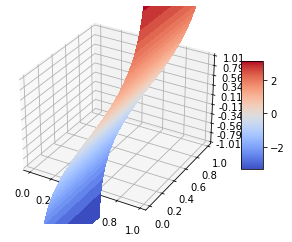

In [122]:
fig = plt.figure()
ax = fig.gca(projection='3d')

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [123]:
# Make data.
X = np.arange(0.01, 0.99, 0.01)
Y = np.arange(0.01, 0.99, 0.01)
X, Y = np.meshgrid(X, Y)
# R = np.sqrt(X**2 + Y**2)
# Z =  np.sin(R)
Z = inv_darmois(np.array([X,Y]))[1]# np.sin(R)

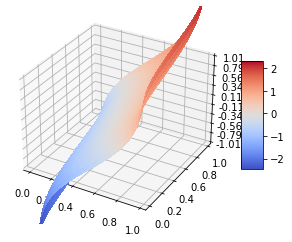

In [124]:
fig = plt.figure()
ax = fig.gca(projection='3d')

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()